## Preprocessing and filtering of molecules generated by a VAE model

In this project, we work with a set of molecules automatically generated by a VAE (*Variational Autoencoder*) model, stored as SMILES strings in a CSV file. Our goal is to filter and prepare these molecules to select those that could have properties compatible with pharmacological use.

The steps followed to clean and filter the molecules are described below, with an emphasis on Lipinski's rules, which allow us to discard unpromising compounds.


First, we use the `pandas` library to read the `molecules.csv` file, which contains a column with the molecules generated in SMILES format. We also read the file of existing molecules in the database `e_coli_molecules.csv`, which contains a column with the molecules in canonical form.


In [1]:
import pandas as pd

# Generated molecules
molecules = pd.read_csv("newMolecules/molecules.csv")
print(f"Generated molecules: {len(molecules)}")
print(molecules.head())

# Known molecules
molecules_known = pd.read_csv("data/e_coli_molecules.csv")
print(f"Known molecules: {len(molecules_known)}")
print(molecules_known.head())


Generated molecules: 1230
  generated_smiles
0              CCO
1       COC1=CC=C1
2          CC1C=N1
3             CCCC
4              C=C
Known molecules: 1405
                              canonical_smiles molecule_chembl_id relation  \
0  CC1(C)N=C(N)N=C(N)N1c1cccc(C[Se]c2ccccc2)c1        CHEMBL20224        =   
1                   COCc1cccc(Cc2cnc(N)nc2N)c1        CHEMBL31462        =   
2                    COc1ccc(Cc2cnc(N)nc2N)cc1        CHEMBL19023        =   
3             CCCCCCCCOc1cccc(Cc2cnc(N)nc2N)c1        CHEMBL31235        =   
4                   Nc1ncc(Cc2cccc(O)c2)c(N)n1        CHEMBL30734        =   

  standard_relation standard_type standard_units  standard_value  \
0                 =            Ki             nM           3.802   
1                 =  Log 1/Ki app            NaN           6.590   
2                 =  Log 1/Ki app            NaN           6.820   
3                 =  Log 1/Ki app            NaN           6.250   
4                 =  Log 1/Ki

### 1. Duplicate removal and comparison with known molecules

In this first stage, we preprocess the set of molecules generated by the model to ensure their validity and uniqueness, and compare the resulting compounds with the database of known molecules active against *Escherichia coli*. This initial comparison allows us to verify whether the model has generated any **already known** molecules.

**Why is this step necessary?**

Generative models, such as those based on variational autoencoders (VAE), often produce molecules that:

- Are **structurally invalid**, i.e., they do not represent a real chemical molecule.
- Are **duplicated**.
- May match **existing molecules**, which can be redundant (if we are looking exclusively for novelty).

**SMILES and the need for canonisation**

Molecules are represented using **SMILES** (*Simplified Molecular Input Line Entry System*) strings, a text notation that encodes chemical structures. However, the same molecule can have multiple different SMILES representations depending on the order of the atoms.

To address this problem, we use **canonical SMILES**, a standardised and unique way of representing a molecule. This allows us to:

- Identify duplicates even if they have a different order in their textual representation.
- Directly compare molecules generated with a reference database.

**What do we do in this section?**

1. **We convert the generated SMILES into valid `Mol` objects** using the RDKit library.
2. **We obtain the canonical form** of each molecule.
3. **We eliminate invalid molecules** (those that could not be parsed).
4. **We eliminate exact duplicates** within the generated set.
5. **We compare with known molecules active against *E. coli*** to detect exact matches.

In [2]:
from rdkit import Chem

# Convert SMILES to Mol objects
molecules["mol"] = molecules["generated_smiles"].apply(Chem.MolFromSmiles)

# Canonical form
molecules["canonical_smiles"] = molecules["mol"].apply(
    lambda mol: Chem.MolToSmiles(mol, canonical=True) if mol else None
)

print(molecules.head())

# Eliminate invalid molecules
molecules = molecules.dropna(subset=["canonical_smiles"])

# Eliminate duplicates
molecules = molecules.drop_duplicates(subset=["canonical_smiles"])

# Comparing with known molecules
duplicated_with_known = molecules[
    molecules["canonical_smiles"].isin(molecules_known["canonical_smiles"])
]

print(f"{len(duplicated_with_known)} exact duplicates were found with known molecules.")

# Remove molecules that already exist in the known database from the generated set
molecules = molecules[~molecules["canonical_smiles"].isin(molecules_known["canonical_smiles"])]

print(f"Total number of molecules generated:{len(molecules)}")

  generated_smiles                                               mol  \
0              CCO  <rdkit.Chem.rdchem.Mol object at 0x7fa7c384d2a0>   
1       COC1=CC=C1  <rdkit.Chem.rdchem.Mol object at 0x7fa7c20ed770>   
2          CC1C=N1  <rdkit.Chem.rdchem.Mol object at 0x7fa7c20ed700>   
3             CCCC  <rdkit.Chem.rdchem.Mol object at 0x7fa7c20ed7e0>   
4              C=C  <rdkit.Chem.rdchem.Mol object at 0x7fa7c20ed850>   

  canonical_smiles  
0              CCO  
1       COC1=CC=C1  
2          CC1C=N1  
3             CCCC  
4              C=C  
18 exact duplicates were found with known molecules.
Total number of molecules generated:435


This step ensures that we only work with chemically valid and unique molecules.

### 2. Define the Lipinski Filter

Lipinski’s rules, also known as the **"Rule of Five,"** are a set of criteria used to evaluate whether a molecule has properties compatible with oral administration in humans.

These rules do not guarantee that a molecule is a drug, but they are useful for filtering out less promising compounds.

The rules are as follows:

| Property                        | Threshold              | Description                                                                 |
|--------------------------------|------------------------|-----------------------------------------------------------------------------|
| Molecular weight (MolWt)       | < 500 daltons          | Large molecules are often poorly absorbed                                   |
| LogP (MolLogP)                 | < 5                    | High lipophilicity can reduce solubility and increase toxicity              |
| Number of H-bond donors (HBD)  | ≤ 5                    | Too many hydrogen bonds can reduce cell permeability                        |
| Number of H-bond acceptors (HBA)| ≤ 10                  | Too many acceptors can also hinder oral absorption                          |

We implement this rule as a function that calculates these descriptors using `RDKit`.

In [3]:
from rdkit.Chem import Descriptors
def passes_lipinski(mol):
    mw = Descriptors.MolWt(mol)                     
    logp = Descriptors.MolLogP(mol)                
    h_donors = Descriptors.NumHDonors(mol)          
    h_acceptors = Descriptors.NumHAcceptors(mol)    
    return (mw < 500 and logp < 5 and h_donors <= 5 and h_acceptors <= 10)

# Applying filter
molecules['passes_lipinski'] = molecules['mol'].apply(passes_lipinski)
molecules = molecules[molecules['passes_lipinski']]
print(f"After Lipinski filter: {len(molecules)} molecules")

After Lipinski filter: 432 molecules


This preprocessing constitutes a fundamental first filter before applying other more advanced methods such as ADMET property prediction or structural similarity.

### 3. Evaluate Structural Similarity with Known Molecules Against *E. coli*

To assess whether the new molecules generated by the model could be relevant as antibacterials, it is useful to compare them with compounds **already known to be active against *E. coli***. A standard way to do this is through **structural similarity** based on *molecular fingerprints* and a metric called **Tanimoto similarity**.

**What is Tanimoto similarity?**

>Tanimoto similarity (also known as the Jaccard index for binary vectors) measures how similar two binary vectors are, such as those generated by molecular fingerprints. It is defined as:
>
>$$
>\text{Tanimoto}(A, B) = \frac{A \cdot B}{|A|^2 + |B|^2 - A \cdot B}
>$$
>
>Where:
>- $A$ and $B$ are two bit vectors (fingerprints),
>- $A \cdot B$ is the number of bits in common (intersection),
>- $|A|$ and $|B|$ are the total number of bits set to 1 (union).
>
>Its value ranges from 0 (no similarity) to 1 (identical).

**What are Morgan fingerprints?**

>Morgan fingerprints (also known as ECFP, *Extended Connectivity Fingerprints*) encode the **local structure** of atoms and their neighbors in a molecule. They are especially useful in tasks such as *molecular similarity* and *drug discovery*.


1405


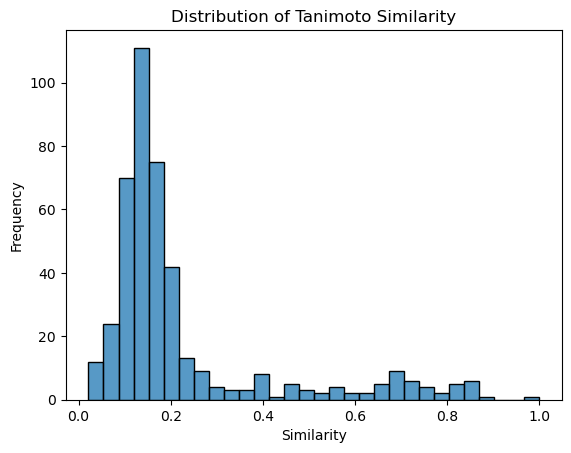

In [4]:
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import TanimotoSimilarity

# --- Step 1: Convert known molecules to RDKit Mol objects ---
molecules_known['mol'] = molecules_known['canonical_smiles'].apply(Chem.MolFromSmiles)
print(len(molecules_known))

# --- Step 2: Generate Morgan (ECFP) fingerprints ---
# Create the generator with:
#    radius=2: number of atom hops around each central atom
#    fpSize=2048: size of the binary vector (number of bits) of the fingerprint
# This is equivalent to the popular ECFP4, commonly used in drug discovery
morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)

# Use the generator to compute fingerprints
known_fps = [morgan_gen.GetFingerprint(mol) for mol in molecules_known['mol']]
generated_fps = molecules['mol'].apply(lambda mol: morgan_gen.GetFingerprint(mol))

# --- Step 3: Compute maximum Tanimoto similarity with known molecules ---
# Define a function that takes a fingerprint and returns the maximum Tanimoto similarity
# between it and the fingerprints of the known molecules.
def max_tanimoto(fp, known_fps):
    return max([TanimotoSimilarity(fp, known_fp) for known_fp in known_fps])

molecules['max_tanimoto'] = generated_fps.apply(lambda fp: max_tanimoto(fp, known_fps))

# --- (Optional) Visualize similarity distribution ---
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(molecules['max_tanimoto'], bins=30)
plt.title("Distribution of Tanimoto Similarity")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.show()



- Most molecules have a low Tanimoto similarity, mainly between 0.1 and 0.3, indicating that the structures evaluated are quite different from previously known compounds. This can be positive if chemical diversity or new active structures are desired.

- There is a long tail to the right, with some molecules having a similarity greater than 0.6, suggesting a certain degree of structural analogy with known active molecules.

- A few compounds with a similarity close to 1 are observed. Although they should not be exactly the same (since known molecules are excluded from the set to be evaluated), such a high similarity could indicate:

    - Possible duplicates in the data (to be reviewed).
    - Very similar molecules but with minor differences
    - Good candidates

In [5]:
# --- Step 4: Check for possible duplicates based on high similarity (> 0.95) ---
from rdkit.Chem import Draw

# Store suspicious matches: (evaluated index, known index, similarity)
duplicates = []

for idx_query, fp in enumerate(generated_fps):
    sims = [TanimotoSimilarity(fp, known_fp) for known_fp in known_fps]
    max_sim = max(sims)
    if max_sim > 0.95:
        idx_known = sims.index(max_sim)
        duplicates.append((idx_query, idx_known, max_sim))

# Show summary
print(f"{len(duplicates)} molecules with similarity > 0.95 were found (possible duplicates).")

# Select the molecule with similarity > 0.95
suspicious_mol = molecules[molecules['max_tanimoto'] > 0.95].iloc[0]

# Show its SMILES
print("SMILES of the suspicious molecule:", suspicious_mol['canonical_smiles'])

# Search in the known dataset for an exact match by SMILES
exact_duplicate = molecules_known[molecules_known['canonical_smiles'] == suspicious_mol['canonical_smiles']]

# Show result
if not exact_duplicate.empty:
    print("An exact match was found in the reference dataset.")
    display(exact_duplicate)
else:
    print("No exact matches found in the reference dataset (high similarity but not identical).")


1 molecules with similarity > 0.95 were found (possible duplicates).
SMILES of the suspicious molecule: CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1
No exact matches found in the reference dataset (high similarity but not identical).


## Train an activity prediction model. First approach:

As a first approach to training the random forest classifier, we use the molecules tested against *E. coli* in the dataset e_coli_molecules.csv as  the set of all active molecules. We then download a second dataset of equal size containing molecules tested against unrelated targets, which we label as inactive. 

The random forest model is trained using Morgan fingerprints as features—bit vectors that encode detailed structural information about each molecule.


In [6]:
import numpy as np
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from sklearn.utils import shuffle

# Load the dataset of inactive molecules from CSV file
molecules_inactive = pd.read_csv("data/random_molecules_custom_columns_1405.csv")

# --- Convert SMILES strings of inactive molecules to RDKit Mol objects ---
molecules_inactive['mol'] = molecules_inactive['canonical_smiles'].apply(Chem.MolFromSmiles)

# --- Generate Morgan fingerprints for inactive molecules using the existing generator (morgan_gen) ---
inactive_fps = [morgan_gen.GetFingerprint(mol) for mol in molecules_inactive['mol']]

# Function to convert list of RDKit fingerprint objects to numpy arrays
def fps_to_array(fps):
    arrs = []
    for fp in fps:
        arr = np.zeros((2048,), dtype=int)  # Initialize empty numpy array for fingerprint bits
        ConvertToNumpyArray(fp, arr)        # Copy fingerprint bits into numpy array
        arrs.append(arr)
    return np.array(arrs)

# Convert known active molecule fingerprints to numpy arrays
x_known = fps_to_array(known_fps)

# Convert inactive molecule fingerprints to numpy arrays
x_inactive = fps_to_array(inactive_fps)

# Create labels: 1 for active molecules, 0 for inactive molecules
y_known = np.ones(len(x_known), dtype=int)
y_inactive = np.zeros(len(x_inactive), dtype=int)

# Combine active and inactive fingerprints vertically into one feature matrix
x = np.vstack([x_known, x_inactive])

# Concatenate the corresponding labels
y = np.concatenate([y_known, y_inactive])

# Shuffle the dataset to mix active and inactive samples randomly
x, y = shuffle(x, y, random_state=42)

# Print the first 10 labels to check
print(y[:10])

# Print the first 10 feature vectors to check
print(x[:10])

# Print the shape of the combined feature matrix
print(x.shape)


[0 0 0 0 1 0 1 0 0 0]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(2810, 2048)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:, 1] 

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       281
           1       0.97      0.99      0.98       281

    accuracy                           0.98       562
   macro avg       0.98      0.98      0.98       562
weighted avg       0.98      0.98      0.98       562

ROC AUC: 0.9940856878712275


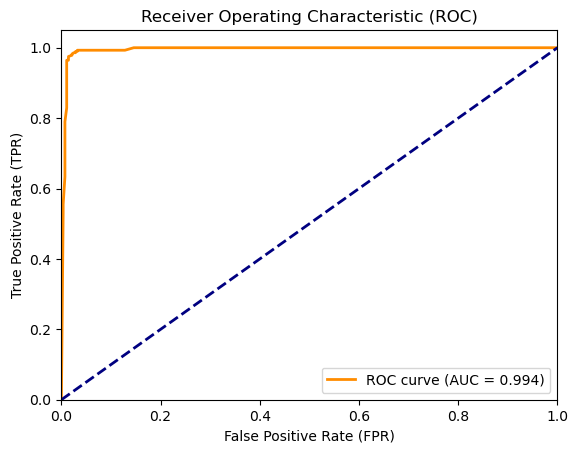

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

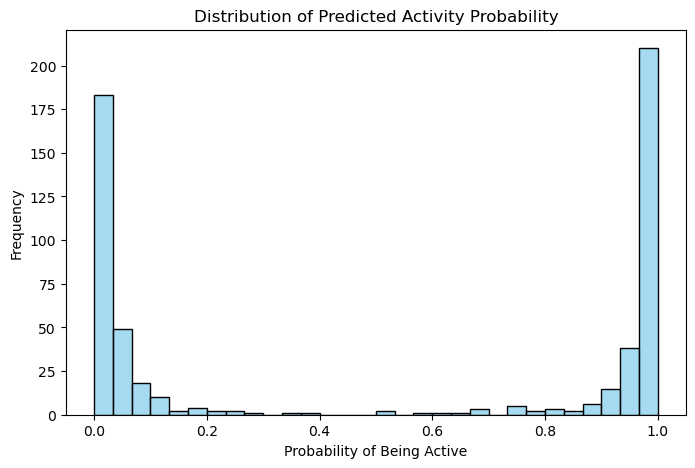

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(y_prob, bins=30, color='skyblue')  # Histogram of predicted activity probabilities
plt.title("Distribution of Predicted Activity Probability")
plt.xlabel("Probability of Being Active")
plt.ylabel("Frequency")
plt.show()

The random forest classifier shows excellent predictive performance, with an AUC of 0.994 and high precision, recall, and F1-scores for both classes. The ROC curve indicates strong class separability, and the histogram of predicted probabilities reveals a clear bimodal distribution. Most predictions are confidently assigned near 0 or 1, suggesting that the model distinguishes well between active and inactive molecules. However, this sharp separation, together with the highly balanced and clean training set, may indicate potential overfitting or a low-complexity classification task, warranting further validation on external or more challenging datasets.

### Model application and results visualization

73 new molecules are predicted to be active


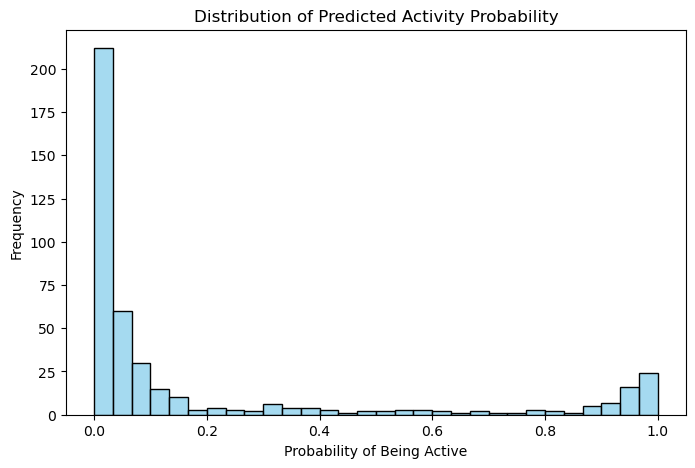

In [10]:
# Convert new molecule fingerprints to numpy arrays
x_new = fps_to_array(generated_fps)

# Predict activity class (0 or 1) for new molecules
preds = clf.predict(x_new)

# Predict probability of being active (probability for class 1)
probs = clf.predict_proba(x_new)[:, 1]

# Add predictions and probabilities as new columns to the dataframe
molecules["predicted_active"] = preds
molecules["prob_active"] = probs

# Filter molecules predicted to be active
actives = molecules[molecules["predicted_active"] == 1]
print(f"{len(actives)} new molecules are predicted to be active")

# Plot histogram of predicted activity probabilities with KDE (kernel density estimate)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(probs, bins=30, color='skyblue')
plt.title("Distribution of Predicted Activity Probability")
plt.xlabel("Probability of Being Active")
plt.ylabel("Frequency")
plt.show()


Number of molecules by estimated activity level:
activity_level
Low       233
Medium     93
High      106
Name: count, dtype: int64


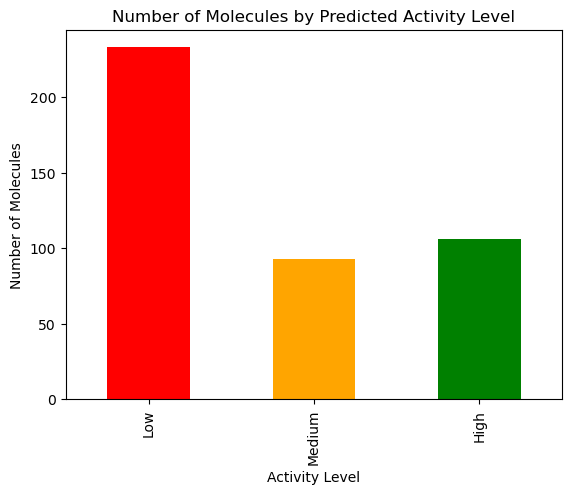

In [11]:
import pandas as pd

# Categorize the predicted probabilities into activity levels: Low, Medium, High
quantiles = np.quantile(probs, [0, 0.5, 0.75, 1.0])  # Define quantiles for Low, Medium, High
#molecules["activity_level"] = pd.cut(probs, bins=quantiles, labels=["Low", "Medium", "High"])
molecules["activity_level"] = pd.qcut(probs, q=[0, 0.5, 0.75, 1.0], labels=["Low", "Medium", "High"])

# Count how many molecules fall into each activity level category
counts = molecules["activity_level"].value_counts().sort_index()

print("Number of molecules by estimated activity level:")
print(counts)

# Bar plot of molecule counts per activity level
counts.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Number of Molecules by Predicted Activity Level")
plt.xlabel("Activity Level")
plt.ylabel("Number of Molecules")
plt.show()

Max similarity in high prob molecules:
count    106.000000
mean       0.487783
std        0.242569
min        0.080000
25%        0.234188
50%        0.474485
75%        0.697498
max        1.000000
Name: max_tanimoto, dtype: float64
\Max similarity in low and high prob molecules:
count    326.000000
mean       0.137350
std        0.046219
min        0.021277
25%        0.108108
50%        0.135135
75%        0.162634
max        0.296296
Name: max_tanimoto, dtype: float64


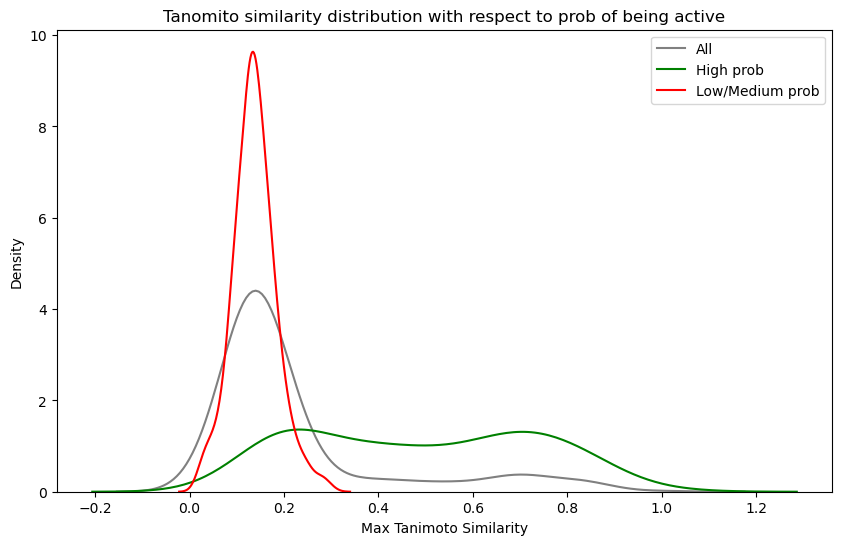

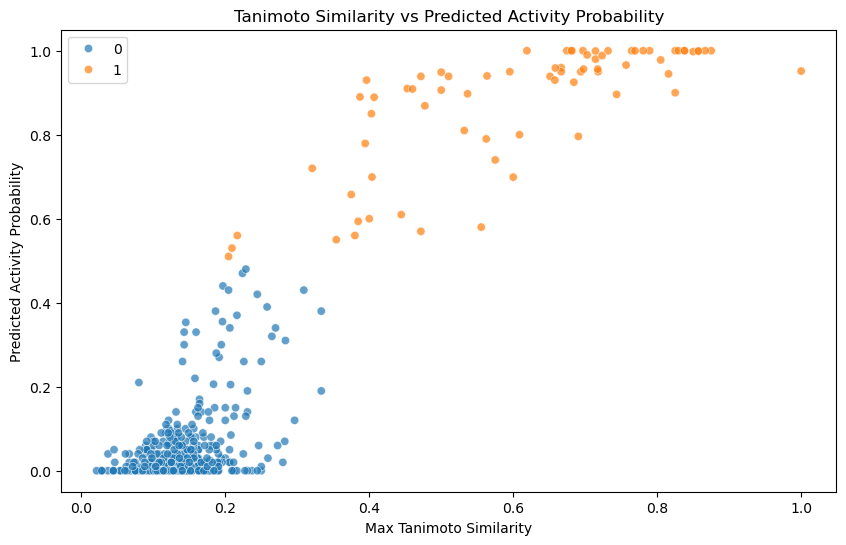

In [12]:
# Filter molecules with high probability of being active
high_prob_mols = molecules[molecules["prob_active"] > quantiles[2]]

# Statistics of maximum Tanimoto similarity for molecules with high probability
print("Max similarity in high prob molecules:")
print(high_prob_mols["max_tanimoto"].describe())

# Compare with low and medium probability molecules
low_prob_mols = molecules[molecules["prob_active"] <= quantiles[2]]

print("\Max similarity in low and high prob molecules:")
print(low_prob_mols["max_tanimoto"].describe())

# Visualize the distribution of maximum Tanimoto similarity for different activity levels
plt.figure(figsize=(10,6))
sns.kdeplot(molecules["max_tanimoto"], label='All', color='gray')
sns.kdeplot(high_prob_mols["max_tanimoto"], label='High prob', color='green')
sns.kdeplot(low_prob_mols["max_tanimoto"], label='Low/Medium prob', color='red')
plt.xlabel("Max Tanimoto Similarity")
plt.ylabel("Density")
plt.title("Tanomito similarity distribution with respect to prob of being active")
plt.legend()
plt.show()


#scatter plot of predicted activity vs max Tanimoto similarity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=molecules, x='max_tanimoto', y='prob_active', hue='predicted_active', alpha=0.7)
plt.title("Tanimoto Similarity vs Predicted Activity Probability")
plt.xlabel("Max Tanimoto Similarity")
plt.ylabel("Predicted Activity Probability")
#plt.axhline(y=0.9, color='red', linestyle='--', label='Threshold (0.9)')
plt.legend()
plt.show() 

##### **Analysis of Results for Group 1 and Group 2**

##### **Group 1: Molecules with High Probability**

* **Number:** 104 molecules
* **Mean:** \~0.42
* **Median (50%):** 0.34
* **75% (Q3):** 0.67
* **Maximum:** 1.0 (molecules identical or very similar to known ones)
* **Minimum:** 0.11 (less similar molecules)

**Interpretation:**

* On average, these molecules show moderate similarity to known compounds (42%).
* The median indicates that a typical molecule has about 34% similarity, a value that is not very high but still meaningful.
* The upper quartile (75%) shows that at least 25% of the molecules have relatively high similarity (> 67%), representing a group chemically close to known molecules.
* Some molecules have low similarity (minimum 11%), which could represent novel structures or possible false positives by the model.

##### **Group 2: Molecules with Low or Medium Probability**

* **Number:** 331 molecules
* **Mean:** \~0.16
* **Median:** 0.14
* **75%:** 0.17
* **Maximum:** 0.83
* **Minimum:** 0.02

**Interpretation:**

* This group shows much lower average similarity to known molecules (16%).
* The median confirms that most of them are poorly similar (14%).
* The maximum value is not very high (83%), indicating that only a few low- or medium-probability molecules are structurally close to known ones.

### **Conclusions**

1. **Positive correlation between predicted activity and chemical similarity:**
   Molecules that the model considers more active (high probability) tend to be more similar to known active compounds, although the average similarity is not very high. This suggests that the model relies on structural features to predict activity.

2. **Potential discovery of novel molecules:**
   Some high-probability molecules show low similarity to known ones, indicating that the model may be capable of identifying potentially novel compounds, although with a certain risk of false positives.

3. **Consistency in predictions for dissimilar molecules:**
   Most low- or medium-probability molecules are structurally dissimilar to known compounds, suggesting that the model appropriately filters out unrelated structures.

The following code selects and visualizes two sets of top-ranked molecules with **high predicted activity** and either **high or low structural similarity** to known compounds. These molecules are exported for visual inspection with RDKit and analyzed further using **ADMETlab** predictions.

**ADMETlab** is an online tool that predicts key pharmacokinetic and toxicity properties—such as **oral bioavailability**, **blood-brain barrier permeability**, **hERG inhibition**, and **Ames toxicity**—using machine learning models. Integrating these predictions helps prioritize compounds that are not only active but also **pharmacologically and toxicologically favorable**, streamlining early-stage **drug discovery**.

                                SMILES
0       CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C
1       CCc1cc(Cc2cnc(N)cc2N)cc(OC)c1O
2        CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1
3         COc1cc(O)cc(Cc2cnc(N)nc2N)c1
4      CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC
5      CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC
6      CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC
7       CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1O
8         COc1cc(C)cc(Cc2cnc(N)nc2N)c1
9   CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC
10     CCc1c(OC)cc(Cc2cnc(N)cc2N)cc1OC
11     CNc1c(OC)cc(Cc2ccc(N)nc2N)cc1OC
12     COc1cc(Cc2ccc(N)nc2N)cc(OC)c1OC
13  CCCCNc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC
14   CC1C=CCON=CC=C(Cc2cnc(N)nc2N)C=C1
15    CONc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC
16          COC1C=CC(Cc2cnc(N)nc2N)=C1
17         CCCc1cc(Cc2cnc(N)nc2N)ccc1C
18     CCc1cc(Cc2ccc(N)nc2C)cc(OC)c1OC
19     CCc1cc(Cc2ccc(N)nc2N)cc(CC)c1SC

 Molecules with High Probability and High Similarity 



/tmp/ipykernel_1124/3547122115.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_high_sim_top10["group"] = "high_sim"
/tmp/ipykernel_1124/3547122115.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_low_sim_top10["group"] = "low_sim"


,canonical_smiles,prob_active,max_tanimoto
16,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C,1.000000,0.825000
28,CCc1cc(Cc2cnc(N)cc2N)cc(OC)c1O,0.900000,0.825000
101,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1,1.000000,0.837838
124,COc1cc(O)cc(Cc2cnc(N)nc2N)c1,0.944833,0.815789
244,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,0.997775,0.850000
284,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC,1.000000,0.875000
306,CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC,0.998647,0.857143
732,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1O,1.000000,0.829268
896,COc1cc(C)cc(Cc2cnc(N)nc2N)c1,1.000000,0.837838
917,CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC,1.000000,0.866667


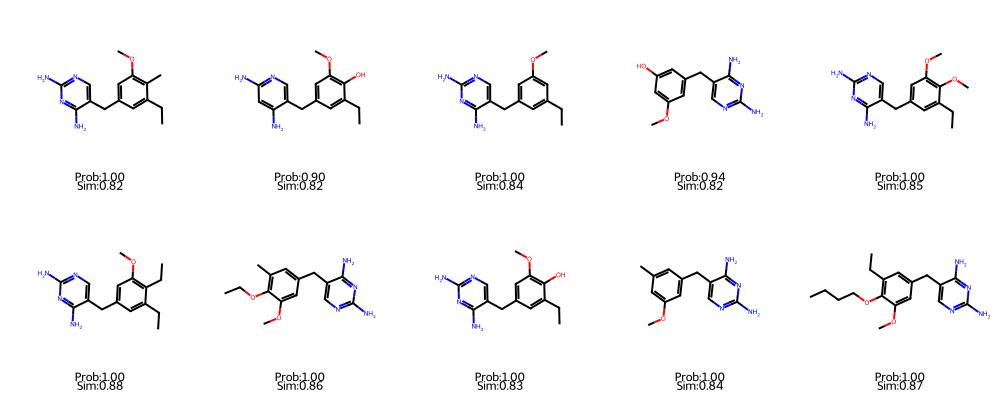


 Molecules with High Probability and Low Similarity 



,canonical_smiles,prob_active,max_tanimoto
8,CCc1c(OC)cc(Cc2cnc(N)cc2N)cc1OC,0.896000,0.743590
45,CNc1c(OC)cc(Cc2ccc(N)nc2N)cc1OC,0.950000,0.717949
69,COc1cc(Cc2ccc(N)nc2N)cc(OC)c1OC,0.965901,0.756757
172,CCCCNc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC,0.950000,0.693878
178,CC1C=CCON=CC=C(Cc2cnc(N)nc2N)C=C1,0.930000,0.396226
206,CONc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC,0.999706,0.731707
232,COC1C=CC(Cc2cnc(N)nc2N)=C1,0.948889,0.500000
275,CCCc1cc(Cc2cnc(N)nc2N)ccc1C,1.000000,0.674419
292,CCc1cc(Cc2ccc(N)nc2C)cc(OC)c1OC,0.810000,0.531915
358,CCc1cc(Cc2ccc(N)nc2N)cc(CC)c1SC,0.925000,0.684211


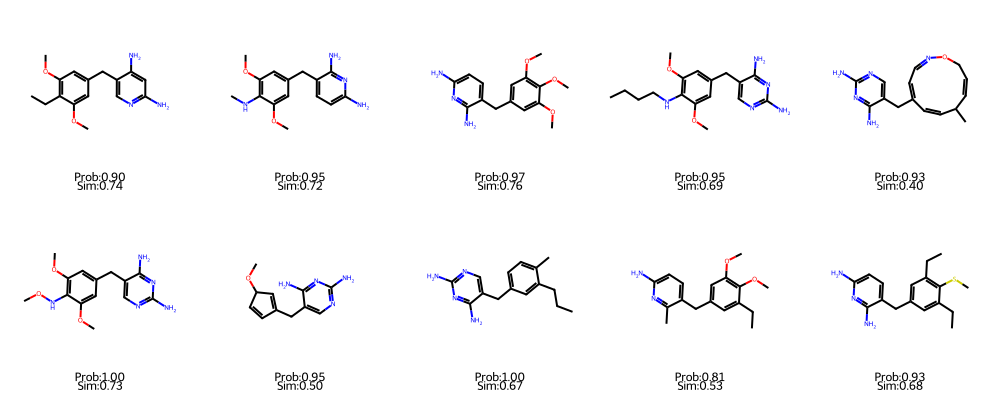

In [13]:
from rdkit.Chem import Draw

# Define thresholds for high probability and high/low similarity
prob_threshold = 0.8
similarity_threshold = 0.8  # you can adjust this value to define "high" similarity

# Filter molecules with high probability and high similarity
high_prob_high_sim = molecules[(molecules['prob_active'] >= prob_threshold) & 
                            (molecules['max_tanimoto'] >= similarity_threshold)].copy()

# Filter molecules with high probability and low similarity
high_prob_low_sim = molecules[(molecules['prob_active'] >= prob_threshold) & 
                            (molecules['max_tanimoto'] < similarity_threshold)].copy()

# Select the top 10 molecules from each group
high_prob_high_sim_top10 = high_prob_high_sim.head(10)
high_prob_low_sim_top10 = high_prob_low_sim.head(10)
high_prob_high_sim_top10["group"] = "high_sim"
high_prob_low_sim_top10["group"] = "low_sim"
smiles_df = pd.concat([high_prob_high_sim_top10, high_prob_low_sim_top10], ignore_index=True)
smiles_only_df = smiles_df[['generated_smiles']]
smiles_only_df.columns = ["SMILES"]
print(smiles_only_df)
smiles_only_df.to_csv("molecules_admetlab.csv", index=False)
# Visualization with RDKit (shows SMILES + index)
# def show_molecules(df, titulo):
#     print(f"\n{titulo}\n")
#     display(df[['canonical_smiles', 'prob_active', 'max_tanimoto']])
#     mols = list(df['mol'])
#     img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200),
#                             legends=[f"Prob:{p:.2f}\nSim:{s:.2f}" 
#                                         for p,s in zip(df['prob_active'], df['max_tanimoto'])])
#     display(img)

def show_molecules(df, title):
    print(f"\n {title} \n")
    display(df[['canonical_smiles', 'prob_active', 'max_tanimoto']])
    valid_df = df[df['mol'].notnull()].copy()
    mols = list(valid_df['mol'])
    legends = [f"Prob:{p:.2f}\nSim:{s:.2f}" for p, s in zip(valid_df['prob_active'], valid_df['max_tanimoto'])]
    if mols:
        img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200),
                                    legends=[f"Prob:{p:.2f}\nSim:{s:.2f}" 
                                                for p,s in zip(df['prob_active'], df['max_tanimoto'])])
        display(img)
    else:
        print("No valid molecules to display.")

# Display and save
show_molecules(high_prob_high_sim_top10, "Molecules with High Probability and High Similarity")
show_molecules(high_prob_low_sim_top10, "Molecules with High Probability and Low Similarity")

In [14]:
# Load ADMETlab results
admet_df = pd.read_csv("newMolecules/admet_results.csv")

# Add the group back (assuming the same order)
admet_df["group"] = smiles_df["group"].values
admet_df["generated_smiles"] = smiles_df["generated_smiles"].values
print(admet_df)
print(admet_df.columns.tolist())

                                               smiles      MW         Vol  \
0                      CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C  272.16  287.841835   
1                       CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1  258.15  270.545850   
2                     CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC  288.16  296.632062   
3                     CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC  286.18  305.137820   
4                     CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC  288.16  296.632062   
5                        COc1cc(C)cc(Cc2cnc(N)nc2N)c1  244.13  253.249865   
6                  CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC  330.21  348.520018   
7   CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...  454.17  431.730958   
8                     CNc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC  289.15  290.332837   
9                    CCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC  302.17  313.928047   
10                                         COC1=CC=C1   82.04   89.997235   
11                    CCc1c(OC)cc(Cc2cnc(N)cc2N)cc1OC  287.16  302.931287   

---

## Second approach:

As a second approach, we only refer to the e_coli_molecules.csv file, containing exclusively molecules tested against E.Coli, as a training dataset. 

To assemble training labels, we set a certain threshold over pChEMBL, the standard-indicator for biological activity, and we define molecules as active or inactive with respect to it. 

Both the reference and newly generated compounds are featurized using 200 RDKit descriptors, capturing key physicochemical and structural properties. These features serve as inputs to the Random Forest classifier.

The pChEMBL value is a standardized, unitless measure of compound potency, defined as the negative base-10 logarithm of various half-maximal activity metrics, such as IC₅₀, EC₅₀, XC₅₀, AC₅₀, Ki, Kd, ED₅₀, or general potency, when expressed in molar units. 

By expressing each of these concentration metrics as pChEMBL, we achieve direct comparability across assays, compress an otherwise vast molar range into a manageable numeric window, and enable the use of a uniform activity cutoff (e.g. pChEMBL ≥ 6) for binary classification. This targeted standardization reduces bias arising from differing assay units and facilitates downstream modeling, particularly Random Forest classifiers, by providing a consistent, biologically meaningful descriptor of molecular efficacy.

Higher values indicate stronger biological activity. By mapping diverse bioactivity endpoints onto a common –log₁₀ scale, pChEMBL allows for direct and consistent comparison of binding affinities and functional potencies across assays and targets.

Commonly used cutoff are pChEMBL = 5, 6 or 7. We decided upon 7 for it yields a more balanced distribution of actives and inactives.

In [15]:
# Import molecules_known with pChEMBL values
molecules_known_with_pChEMBL = pd.read_csv("data/e_coli_molecules_with_pchembValue.csv")
molecules_known_with_pChEMBL = molecules_known_with_pChEMBL.dropna(subset=['pchembl_value']).copy()
print(f"Number of molecules with pChEMBL: {len(molecules_known_with_pChEMBL)}")

Number of molecules with pChEMBL: 749


In [16]:
# print quartiles of pChEMBL values
print("Quartiles of pChEMBL values:")
print(molecules_known_with_pChEMBL['pchembl_value'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

Quartiles of pChEMBL values:
0.25     5.9400
0.50     6.8600
0.75     7.9400
0.90     8.5960
0.95     9.0700
0.99    10.4756
Name: pchembl_value, dtype: float64


In [17]:
# Assign labels active or inactive based on pChEMBL value
molecules_known_with_pChEMBL['active'] = (molecules_known_with_pChEMBL['pchembl_value'] >=7).astype(int)

#how many active and inactive molecules?
active_count = molecules_known_with_pChEMBL['active'].sum()
inactive_count = len(molecules_known_with_pChEMBL) - active_count
print(f"Number of active molecules: {active_count}")
print(f"Number of inactive molecules: {inactive_count}")

Number of active molecules: 345
Number of inactive molecules: 404


Random forest is well-suited for scenarios with a high number of features, such as this dataset with 200 variables. By randomly selecting a subset of features at each split, it helps reduce overfitting through tree decorrelation. 

In [18]:
from rdkit import Chem
# Convert SMILES to Mol objects
molecules_known_with_pChEMBL["mol"] = molecules_known_with_pChEMBL["canonical_smiles"].apply(Chem.MolFromSmiles)

In [19]:
# generate 200 RDKit indicators for each molecule in unique_molecules_with_pChEMBL

from rdkit.Chem import Descriptors
def generate_rdkit_indicators(mol):
    if mol is None:
        return [None] * 200
    indicators = []
    for desc in Descriptors.descList:
        try:
            value = desc[1](mol)
            indicators.append(value)
        except Exception as e:
            indicators.append(None)  # Handle cases where descriptor calculation fails
    return indicators

# Apply the function to generate indicators for unique molecules with pChEMBL
molecules_known_with_pChEMBL['rdkit_indicators'] = molecules_known_with_pChEMBL['mol'].apply(generate_rdkit_indicators)

# Get the names of the descriptors
descriptor_names = [desc[0] for desc in Descriptors.descList]
if len(descriptor_names) < 217:
    descriptor_names += [f"unknown_desc_{i+1}" for i in range(217 - len(descriptor_names))]
elif len(descriptor_names) > 217:
    descriptor_names = descriptor_names[:217]

# Convert the list of indicators into separate columns
indicators_df = pd.DataFrame(molecules_known_with_pChEMBL['rdkit_indicators'].tolist(), 
                             columns=descriptor_names)

# Concatenate with the original dataset
unique_molecules_with_pChEMBL_indicators = pd.concat([molecules_known_with_pChEMBL.reset_index(drop=True), 
                                                       indicators_df.reset_index(drop=True)], axis=1)

# Save the DataFrame with indicators to a new CSV file
unique_molecules_with_pChEMBL_indicators.to_csv("data/unique_molecules_with_pChEMBL_indicators.csv", index=False)
# Display the first few rows of the DataFrame with indicators
print(unique_molecules_with_pChEMBL_indicators.head())

print(f"Number of unique molecules with pChEMBL indicators: {len(unique_molecules_with_pChEMBL_indicators)}")
print(indicators_df.shape)

                                    canonical_smiles molecule_chembl_id  \
0        CC1(C)N=C(N)N=C(N)N1c1cccc(C[Se]c2ccccc2)c1        CHEMBL20224   
1                   CCc1cccc(N2C(N)=NC(N)=NC2(C)C)c1        CHEMBL20874   
2               CC1(C)N=C(N)N=C(N)N1c1ccc(C(N)=O)cc1       CHEMBL284553   
3                   CC1(C)N=C(N)N=C(N)N1c1cccc(Cl)c1         CHEMBL7130   
4  CC1(C)N=C(N)N=C(N)N1c1ccc(CCCCc2ccc(S(=O)(=O)F...        CHEMBL33697   

   pchembl_value relation standard_relation standard_type standard_units  \
0           8.42        =                 =            Ki             nM   
1           7.22        =                 =            Ki             nM   
2           4.70        =                 =            Ki             nM   
3           7.65        =                 =            Ki             nM   
4           8.99        =                 =            Ki             nM   

   standard_value      type units  ...  fr_sulfide  fr_sulfonamd fr_sulfone  \
0           3

In [20]:
# train a random forest classifier over unique_molecules_with_pChEMBL_indicators with cross validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Features and target variable
X = pd.DataFrame(
    molecules_known_with_pChEMBL['rdkit_indicators'].tolist(),
    columns=descriptor_names
)
y = molecules_known_with_pChEMBL['active']
print(X.shape, y.shape)

(749, 217) (749,)


In [21]:
# split train and test set and performe a simple random forest classifier without cross validation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# Fit the classifier on the training data
rf_classifier.fit(X_train, y_train)
# Evaluate the classifier on the test data
accuracy = rf_classifier.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}") 


Test accuracy: 0.82


In [22]:
# Predict the probabilities of the test set
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
y_pred = rf_classifier.predict(X_test)
# Calculate the ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC score: {roc_auc:.2f}")  
# Calculate the classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Classification report:\n", report)

ROC AUC score: 0.92
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84        81
           1       0.83      0.77      0.80        69

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



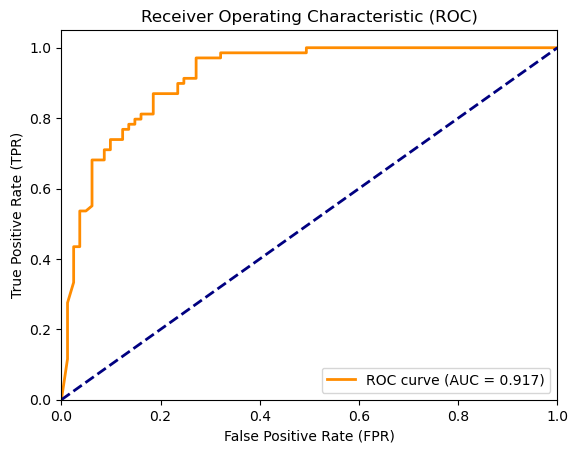

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

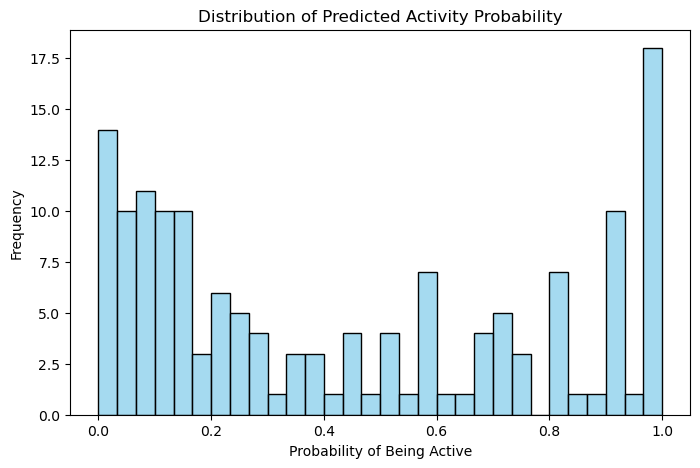

In [24]:
# Histogram of predicted activity probabilities on test set

plt.figure(figsize=(8,5))
sns.histplot(y_prob, bins=30, color='skyblue') 
plt.title("Distribution of Predicted Activity Probability")
plt.xlabel("Probability of Being Active")
plt.ylabel("Frequency")
plt.show()

The model shows **solid predictive performance**, with an **accuracy of 82%** and an **AUC of 0.92**, indicating good class separability. Precision and recall are balanced across both classes, and the **ROC curve** supports the model's reliability. However, compared to a previous model with sharper separation, these results suggest a **more realistic and robust performance**, likely due to a **more complex or diverse dataset**. This is further reflected in the **distribution of predicted activity probabilities**, which appears more **dispersed and less bimodal**. Many predictions fall in the intermediate range (0.2–0.8), indicating **greater model uncertainty** and a **less clear-cut distinction** between active and inactive compounds. These softer probability outputs may reflect improved generalization, but also emphasize the need for **careful threshold tuning**, and potentially further data enrichment or feature engineering to enhance predictive confidence.


### Model application and result visualization

In [25]:
# Add 200 RDKit indicators to the molecules DataFrame
molecules["rdkit_indicators"] = molecules["mol"].apply(generate_rdkit_indicators)
# Convert the list of indicators into separate columns
indicators_df = pd.DataFrame(molecules['rdkit_indicators'].tolist(), 
                             columns=descriptor_names)
# Concatenate with the original dataset
molecules_with_indicators = pd.concat([molecules.reset_index(drop=True),
                                       indicators_df.reset_index(drop=True)], axis=1)   
# Save the DataFrame with indicators to a new CSV file
molecules_with_indicators.to_csv("data/molecules_with_indicators.csv", index=False)

41 new molecules are predicted to be active


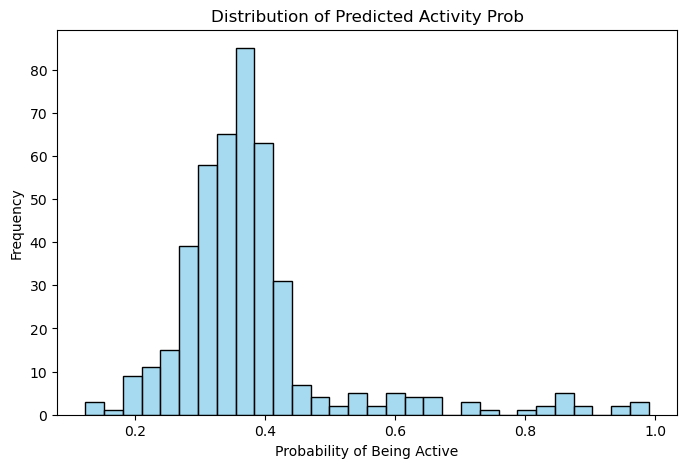

In [26]:
# Input features to classfy new molecules
x_new_2 = pd.DataFrame(molecules['rdkit_indicators'].tolist(), 
                             columns=descriptor_names)

# Predict activity class (0 or 1) for new molecules
preds_2 = rf_classifier.predict(x_new_2)

# Predict probability of being active (probability for class 1)
probs_2 = rf_classifier.predict_proba(x_new_2)[:, 1]

# Add predictions and probabilities as new columns to the dataframe
molecules["predicted_active_2"] = preds_2
molecules["prob_active_2"] = probs_2

# Filter molecules predicted to be active
actives_2 = molecules[molecules["predicted_active_2"] == 1]
print(f"{len(actives_2)} new molecules are predicted to be active")

# Plot histogram of predicted activity probabilities with KDE (kernel density estimate)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(probs_2, bins=30, color='skyblue')
plt.title("Distribution of Predicted Activity Prob")
plt.xlabel("Probability of Being Active")
plt.ylabel("Frequency")
plt.show()


Number of molecules by estimated activity level:
activity_level_2
Low       215
Medium    109
High      107
Name: count, dtype: int64


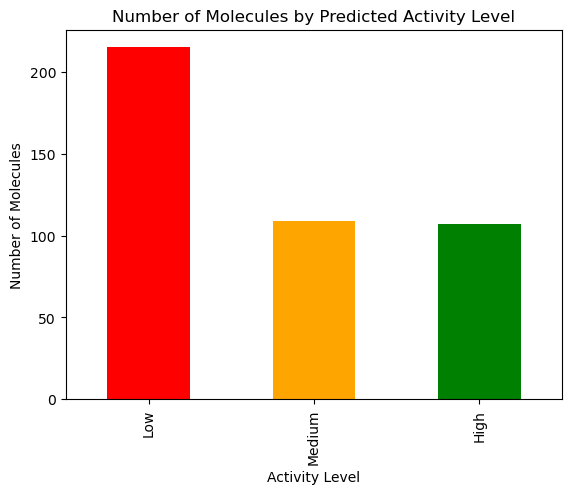

In [27]:
import pandas as pd

# Categorize the predicted probabilities into activity levels: Low, Medium, High
quantiles_2 = np.quantile(probs_2, [0, 0.5, 0.75, 1.0])
molecules["activity_level_2"] = pd.cut(probs_2, bins=quantiles_2, labels=["Low", "Medium", "High"])
# pd.cut(probs_2, bins=[0, 0.7, 0.9, 1.0], labels=["Low", "Medium", "High"])

# Count how many molecules fall into each activity level category
counts_2 = molecules["activity_level_2"].value_counts().sort_index()

print("Number of molecules by estimated activity level:")
print(counts_2)

# Bar plot of molecule counts per activity level
counts_2.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Number of Molecules by Predicted Activity Level")
plt.xlabel("Activity Level")
plt.ylabel("Number of Molecules")
plt.show()

Max similarity in high prob molecules:
count    107.000000
mean       0.397861
std        0.284646
min        0.027778
25%        0.141196
50%        0.296296
75%        0.683014
max        1.000000
Name: max_tanimoto, dtype: float64

Max similarity in low and high prob molecules:
count    325.000000
mean       0.165877
std        0.107940
min        0.021277
25%        0.115385
50%        0.142857
75%        0.178082
max        0.837838
Name: max_tanimoto, dtype: float64


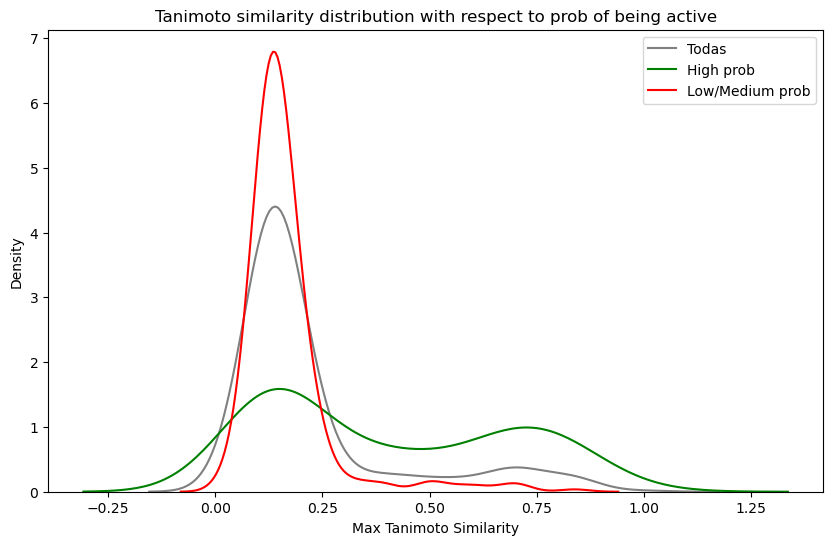

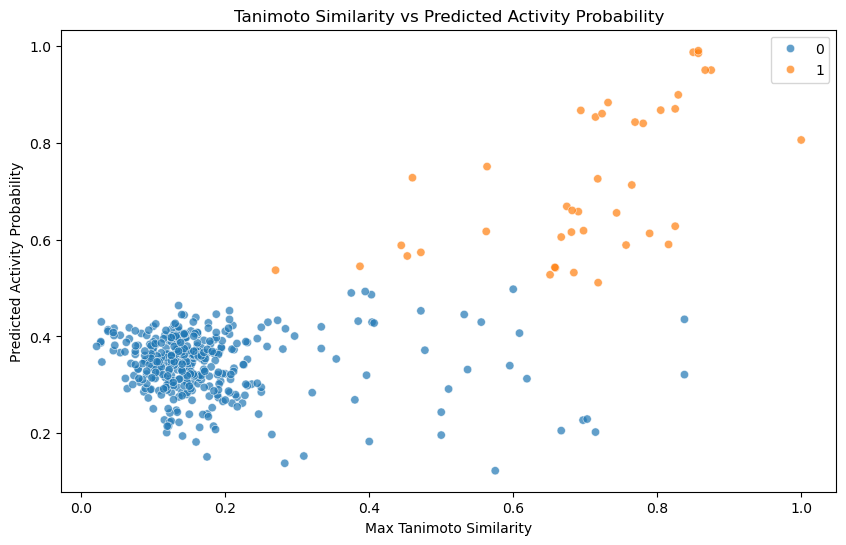

In [28]:
# Filter molecules with high probability

high_prob_mols_2 = molecules[molecules["prob_active_2"] > quantiles_2[2]]

# Statistics of maximum Tanimoto similarity for molecules with high probability
print("Max similarity in high prob molecules:")
print(high_prob_mols_2["max_tanimoto"].describe())

# Compare with low and medium probability molecules
low_prob_mols_2 = molecules[molecules["prob_active_2"] <= quantiles_2[2]]

print("\nMax similarity in low and high prob molecules:")
print(low_prob_mols_2["max_tanimoto"].describe())

# Visualize the distribution of maximum Tanimoto similarity for different activity levels
plt.figure(figsize=(10,6))
sns.kdeplot(molecules["max_tanimoto"], label='Todas', color='gray')
sns.kdeplot(high_prob_mols_2["max_tanimoto"], label='High prob', color='green')
sns.kdeplot(low_prob_mols_2["max_tanimoto"], label='Low/Medium prob', color='red')
plt.xlabel("Max Tanimoto Similarity")
plt.ylabel("Density")
plt.title("Tanimoto similarity distribution with respect to prob of being active")
plt.legend()
plt.show()

#scatter plot of predicted activity vs max Tanimoto similarity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=molecules, x='max_tanimoto', y='prob_active_2', hue='predicted_active_2', alpha=0.7)
plt.title("Tanimoto Similarity vs Predicted Activity Probability")
plt.xlabel("Max Tanimoto Similarity")
plt.ylabel("Predicted Activity Probability")
# plt.axhline(y=quantiles[2], color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()  

bla = molecules.to_csv("newMolecules/bla.csv", index=False)

The high-probability group spans a broader similarity range, including some molecules with moderate or even low similarity. This supports the idea that the model can potentially identify novel active compounds, beyond those that are closely related to known actives—although such predictions may carry higher uncertainty and merit further validation.

                                               SMILES
0                      CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C
1                     CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC
2                     CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC
3                     CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC
4                      CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1O
5                  CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC
6   CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...
7                     CNc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC
8                    CCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC
9                  CCCCNc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC
10                   CONc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC
11              COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC(CO)OO
12                   CCOOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC
13                  CCCCCOc1cc(Cc2cnc(N)nc2N)cc(OC)c1
14                    CNc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC

 Molecules with High Probability and High Similarity 



/tmp/ipykernel_1124/1923654013.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_high_sim_top10_2["group"] = "high_sim"
/tmp/ipykernel_1124/1923654013.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_low_sim_top10_2["group"] = "low_sim"


,canonical_smiles,prob_active,max_tanimoto
16,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C,1.000000,0.825000
244,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,0.997775,0.850000
284,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC,1.000000,0.875000
306,CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC,0.998647,0.857143
732,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1O,1.000000,0.829268
917,CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC,1.000000,0.866667
922,CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...,0.951516,1.000000
1043,CNc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,0.978054,0.804878
1229,CCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC,0.999361,0.857143


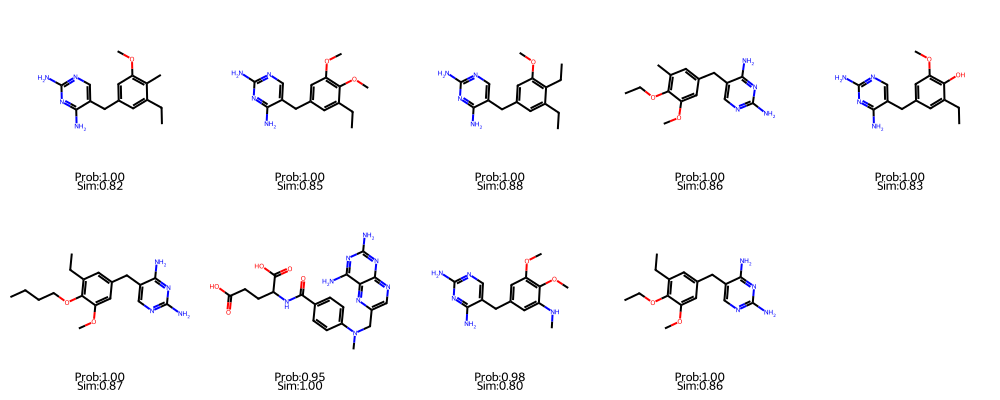


 Molecules with High Probability and Low Similarity 



,canonical_smiles,prob_active,max_tanimoto
172,CCCCNc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC,0.950000,0.693878
206,CONc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC,0.999706,0.731707
709,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC(CO)OO,0.999222,0.714286
991,CCOOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC,0.988403,0.723404
998,CCCCCOc1cc(Cc2cnc(N)nc2N)cc(OC)c1,1.000000,0.780488
1031,CNc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC,0.999706,0.769231


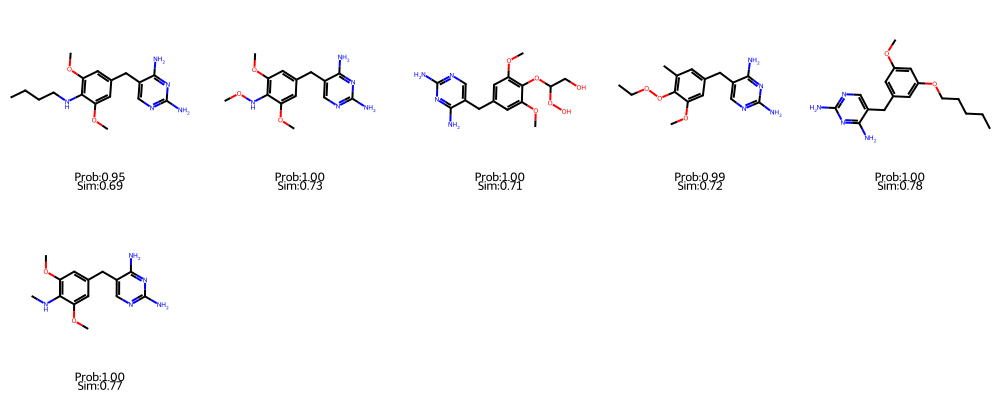

In [29]:
from rdkit.Chem import Draw

# Define thresholds for high probability and high/low similarity
prob_threshold = 0.8
similarity_threshold = 0.8  # you can adjust this value to define "high" similarity

# Filter molecules with high probability and high similarity
high_prob_high_sim_2 = molecules[(molecules["prob_active_2"] >= prob_threshold) & 
                            (molecules['max_tanimoto'] >= similarity_threshold)].copy()

# Filter molecules with high probability and low similarity
high_prob_low_sim_2 = molecules[(molecules["prob_active_2"] >= prob_threshold) & 
                            (molecules['max_tanimoto'] < similarity_threshold)].copy()

# Select the top 10 molecules from each group
high_prob_high_sim_top10_2 = high_prob_high_sim_2.head(10)
high_prob_low_sim_top10_2 = high_prob_low_sim_2.head(10)
high_prob_high_sim_top10_2["group"] = "high_sim"
high_prob_low_sim_top10_2["group"] = "low_sim"
smiles_df_2 = pd.concat([high_prob_high_sim_top10_2, high_prob_low_sim_top10_2], ignore_index=True)
smiles_only_df_2 = smiles_df_2[['generated_smiles']]
smiles_only_df_2.columns = ["SMILES"]
print(smiles_only_df_2)
smiles_only_df_2.to_csv("molecules_admetlab_2.csv", index=False)

# Visualization with RDKit (shows SMILES + index)
show_molecules(high_prob_high_sim_top10_2, "Molecules with High Probability and High Similarity")
show_molecules(high_prob_low_sim_top10_2, "Molecules with High Probability and Low Similarity")

### Top molecules from both approaches for further analysis 

Number of common molecules in high similarity lists: 6
Number of common molecules in low similarity lists: 2

 Common High Similarity Molecules 



,canonical_smiles,prob_active,max_tanimoto
16,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1C,1.000000,0.825000
244,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,0.997775,0.850000
284,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1CC,1.000000,0.875000
306,CCOc1c(C)cc(Cc2cnc(N)nc2N)cc1OC,0.998647,0.857143
732,CCc1cc(Cc2cnc(N)nc2N)cc(OC)c1O,1.000000,0.829268
917,CCCCOc1c(CC)cc(Cc2cnc(N)nc2N)cc1OC,1.000000,0.866667


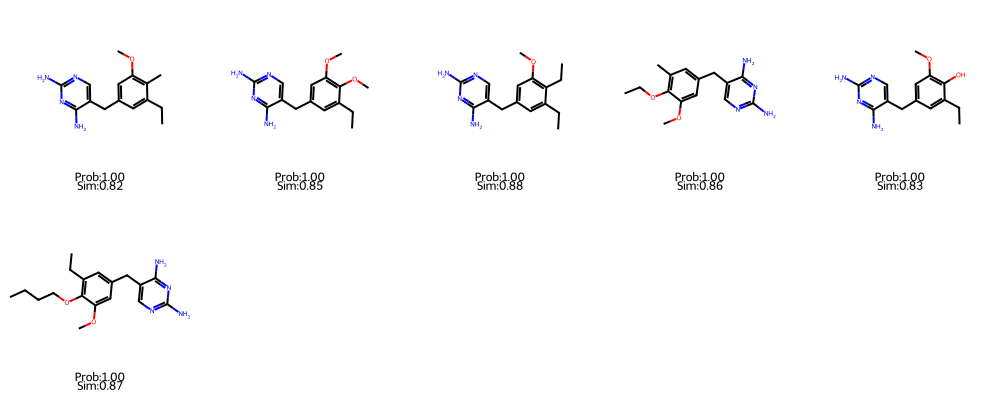


 Common Low Similarity Molecules 



,canonical_smiles,prob_active,max_tanimoto
172,CCCCNc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC,0.950000,0.693878
206,CONc1c(OC)cc(Cc2cnc(N)nc2N)cc1OC,0.999706,0.731707


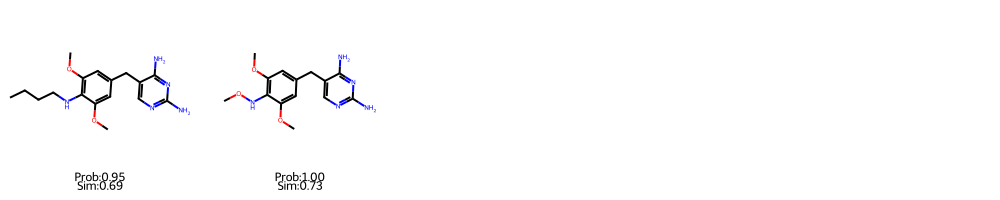

In [49]:
# how many molecules in the 2 top high similarity lists are the same between the two runs?
common_high_sim = pd.merge(high_prob_high_sim_top10, high_prob_high_sim_top10_2, on='generated_smiles')
print(f"Number of common molecules in high similarity lists: {len(common_high_sim)}")
# flag this molecules as common in the molecules DataFrame
molecules['common_high_sim'] = molecules["generated_smiles"].isin(common_high_sim['generated_smiles'])


# how many molecules in the 2 top low similarity lists are the same between the two runs?
common_low_sim = pd.merge(high_prob_low_sim_top10, high_prob_low_sim_top10_2, on='generated_smiles')
print(f"Number of common molecules in low similarity lists: {len(common_low_sim)}")
# flag this molecules as common in the molecules DataFrame
molecules['common_low_sim'] = molecules["generated_smiles"].isin(common_low_sim['generated_smiles'])

#print only flagged molecules from both groups using RDKit 
show_molecules(molecules[molecules['common_high_sim']], "Common High Similarity Molecules")
show_molecules(molecules[molecules['common_low_sim']], "Common Low Similarity Molecules")
